## Importing Required Dependencies

In [134]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
%matplotlib inline
from imblearn.combine import SMOTEENN
import keras_tuner as kt 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner as kt 
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Preparation

###  Load and Prepare Data

In [135]:
my_df=pd.read_csv('./data.csv')

In [136]:
X = my_df.drop(columns=['label']).values
y = my_df['label'].values

### One-Hot Encoding

In [140]:
y=np.array(pd.get_dummies(y,dtype=int))

### SMOTE for Balanced Sampling

In [112]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assuming X and y are your features and target labels
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert one-hot encoded labels back to class labels
y_resampled_labels = np.argmax(y_resampled, axis=1)

# Check the distribution of data after resampling
counter = Counter(y_resampled_labels)
print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({3: 1000, 2: 1000, 1: 1000, 0: 1000, 9: 1000, 6: 1000, 8: 1000, 5: 1000, 7: 1000, 4: 1000})


In [ ]:
num_labels=10

### Data Split

In [143]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=0)

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'standard_scaler_cnn_1d.pkl')

In [145]:
# Reshape the input data to be 3D for the GRU layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Hyperparameter Tuning

### Function build_model

In [117]:

def build_gru_model(hp):
    model = Sequential()

    # GRU Layer with 3D input shape
    model.add(GRU(
        units=hp.Int('units_gru', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_gru', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(1, 40),  # changed to 3D
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_gru', min_value=0, max_value=0.5, step=0.1)))

    # Final layer
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [120]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hyperparameter tuning with Keras Tuner
possible_epochs = [50, 100]

for epoch_count in possible_epochs:
    tuner = kt.GridSearch(
        build_gru_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir_gru',
        project_name=f'audio_classification_gru_{epoch_count}'
    )

    tuner.search(X_train, y_train,
                 epochs=epoch_count,
                 validation_split=0.2,
                 callbacks=[early_stopping])

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {epoch_count} epochs: {best_hps.values}")



Reloading Tuner from tuner_dir_gru/audio_classification_gru_50/tuner0.json
Best hyperparameters for 50 epochs: {'units_gru': 32, 'activation_gru': 'relu', 'dropout_gru': 0.0, 'learning_rate': 0.01}
Reloading Tuner from tuner_dir_gru/audio_classification_gru_100/tuner0.json
Best hyperparameters for 100 epochs: {'units_gru': 32, 'activation_gru': 'relu', 'dropout_gru': 0.1, 'learning_rate': 0.001}


In [96]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [97]:
best_model.save('best_gru_model.keras')

### Best Model Test

In [98]:
test_accuracy=best_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8464999794960022


### Best hyperparameters

In [122]:
import pandas as pd
import keras_tuner as kt

# Initialize a list to hold dictionaries of hyperparameters for each epoch count
hyperparameters_list = []

# List of possible epochs you want to analyze
possible_epochs = [50, 100]

for epoch_count in possible_epochs:
    # Initialize the tuner with the GRU model
    tuner = kt.GridSearch(
        build_gru_model,  # Ensure you use your existing function for model building
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir_gru',
        project_name=f'audio_classification_gru_{epoch_count}'
    )

    # Perform the search with the current epoch count
    tuner.search(X_train, y_train,
                 epochs=epoch_count,
                 validation_split=0.2,
                 callbacks=[early_stopping])

    # Get best hyperparameters for the current epoch count
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values

    # Add the epoch count to the dictionary of hyperparameters
    hyperparameters = {"epoch_count": epoch_count, **best_hyperparameters}

    # Append the dictionary to the list
    hyperparameters_list.append(hyperparameters)

# Create a DataFrame from the list of hyperparameter dictionaries
best_params_df = pd.DataFrame(hyperparameters_list)


Reloading Tuner from tuner_dir_gru/audio_classification_gru_50/tuner0.json
Reloading Tuner from tuner_dir_gru/audio_classification_gru_100/tuner0.json


In [123]:
best_params_df

,epoch_count,units_gru,activation_gru,dropout_gru,learning_rate
0,50,32,relu,0.0,0.010
1,100,32,relu,0.1,0.001


In [99]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
units_gru: 32
activation_gru: relu
dropout_gru: 0.1
learning_rate: 0.001


In [149]:
import pandas as pd

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a pandas DataFrame
hyperparameters_df = pd.DataFrame(list(best_hyperparameters.values.items()), columns=["Hyperparameter", "Value"])

In [150]:
hyperparameters_df

,Hyperparameter,Value
0,units_gru,32
1,activation_gru,relu
2,dropout_gru,0.1
3,learning_rate,0.001


## Train the Best Model again

Epoch 1/100
175/175 [==============================] - 2s 3ms/step - loss: 2.0916 - accuracy: 0.2797 - val_loss: 1.8052 - val_accuracy: 0.4123
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 1.5957 - accuracy: 0.4860 - val_loss: 1.4351 - val_accuracy: 0.5326
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 1.3431 - accuracy: 0.5592 - val_loss: 1.2605 - val_accuracy: 0.5934
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 1.2055 - accuracy: 0.6049 - val_loss: 1.1639 - val_accuracy: 0.6156
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 1.1320 - accuracy: 0.6272 - val_loss: 1.0953 - val_accuracy: 0.6371
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 1.0770 - accuracy: 0.6510 - val_loss: 1.0494 - val_accuracy: 0.6528
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 1.0184 - accuracy: 0.6679 - val_loss: 1.0041 - val_accuracy: 0.6664

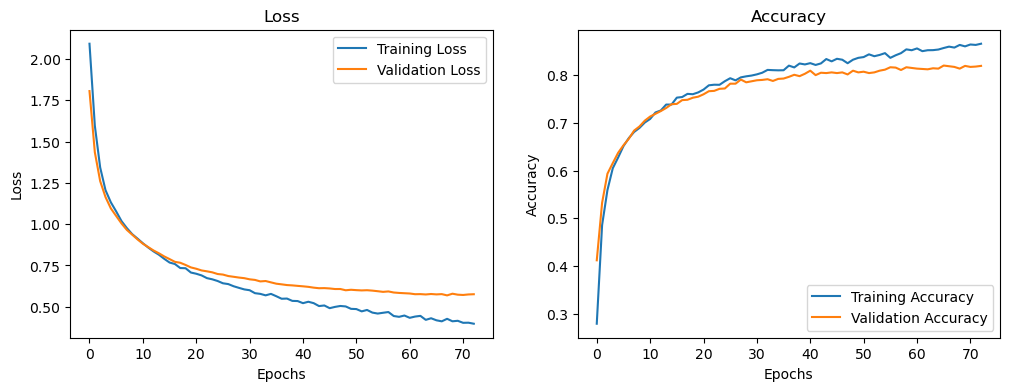

In [146]:
# Rebuild the best model using the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

model = build_gru_model(best_hyperparameters)

# Train the model again, this time keeping track of the history for plotting
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can set an appropriate number of epochs here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [101]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8309999704360962


In [151]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                7104      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 7434 (29.04 KB)
Trainable params: 7434 (29.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Classification report

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Example of class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Get the class labels from the one-hot encoded predictions and true values
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


55/55 [==============================] - 0s 942us/step
                  precision    recall  f1-score   support

 air_conditioner       0.55      0.96      0.70       195
        car_horn       0.96      0.77      0.85        91
children_playing       0.72      0.67      0.69       205
        dog_bark       0.85      0.67      0.75       182
        drilling       0.88      0.82      0.85       202
   engine_idling       0.90      0.87      0.88       216
        gun_shot       0.94      0.70      0.80        87
      jackhammer       0.91      0.91      0.91       187
           siren       0.93      0.88      0.90       199
    street_music       0.64      0.56      0.60       183

        accuracy                           0.79      1747
       macro avg       0.83      0.78      0.79      1747
    weighted avg       0.81      0.79      0.79      1747



## confusion matrix

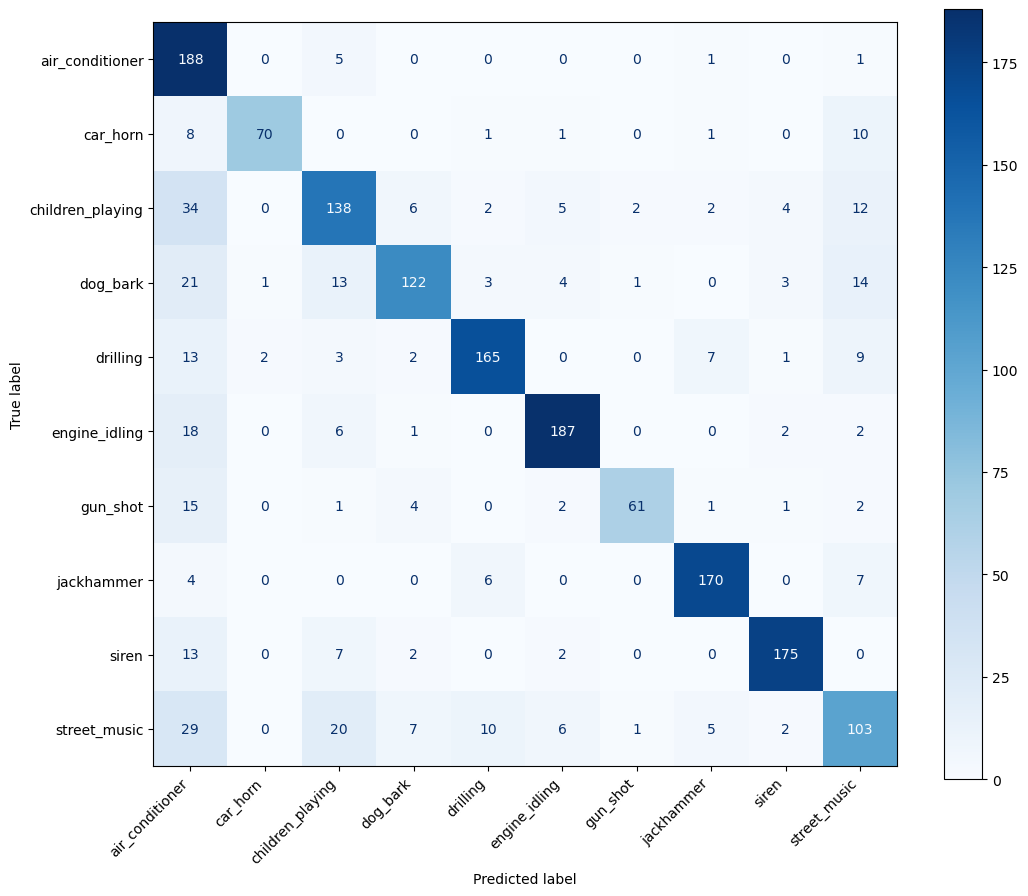

In [153]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Specify figure size directly in subplots

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the axis to the plot method

ax.set_xticklabels(disp.display_labels, rotation=45, ha='right')  # Rotate class names on x-axis for better readability

plt.show()